In [1]:
import os
import numpy as np
import h5py
from plotting import data_plot, hf_format
from NN.Generators import DataGenerator_kspace_to_img
from NN.architectures import reconGAN_Unet_kspace_to_img, my_ssim
from utils.fastMRI_utils import ifft, fft
import matplotlib.pyplot as plt
import SimpleITK as sitk
import tensorflow as tf
from tensorflow.keras.models import model_from_json
tf.config.set_visible_devices([],'GPU')

In [2]:
model_path = r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices\trainingsaves_ReconGAN_Unet_img_to_kspace__l2_Mar_16_13_14'
json_file = os.path.join(model_path,'model_save.json')
if os.path.isfile(json_file):
    json_file = open(json_file, 'r')
    model = model_from_json(json_file.read())
    json_file.close()

data_file_path = '\\'.join(model_path.split('\\')[:-1]+['val','file1000000.h5'])

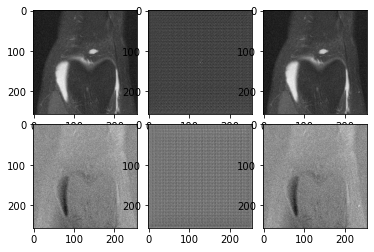

In [7]:
f = h5py.File(data_file_path,'r')
comp = f['image_ground_truth'].value
inp = f['kspace_ground_truth'].value
pred = model.predict(inp)
inp[:,:,:,0], inp[:,:,:,1] = hf_format(inp[:,:,:,0],inp[:,:,:,1],is_realim=True,output_ri=True)
# outp[:,:,:,0], outp[:,:,:,1] = hf_format(outp[:,:,:,0],outp[:,:,:,1],False,True)
compl_img = ifft(inp[0,:,:,0]+1j*inp[0,:,:,1])
outp = np.zeros(inp.shape)
outp[0,:,:,0] = np.real(compl_img)
outp[0,:,:,1] = np.imag(compl_img)
data_plot([comp[0],pred[0],outp[0]])

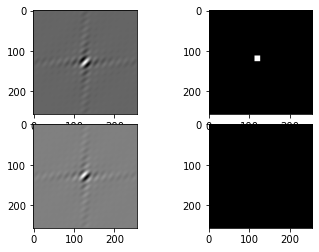

In [4]:
ks_test = np.zeros((256,256),dtype=np.complex)
# ks_test[:,:] += 10000
ks_test[112:126,112:126] += 10000
img_test = ifft(ks_test)
displ = np.zeros((256,256,2))
displ[:,:,0] = np.real(img_test)
displ[:,:,1] = np.imag(img_test)
displ2 = np.zeros((256,256,2))
displ2[:,:,0] = np.real(ks_test)
displ2[:,:,1] = np.imag(ks_test)
data_plot([displ,displ2])

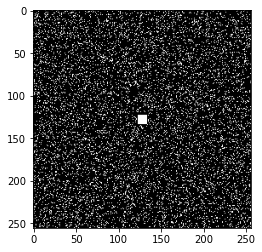

In [11]:
import matplotlib.pyplot as plt
from NN.Masks import CenteredRandomMask
input_mask = CenteredRandomMask(acceleration=8, center_fraction=(4./100.), seed=0xdeadbeef)
to_mask = np.ones((256,256))
plt.imshow(input_mask(to_mask),cmap='gray')
plt.show()

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True False  True]
 [ True  True  True ...  True False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [False False  True ...  True False  True]]
0.15130615234375


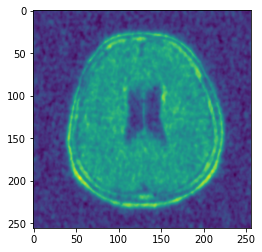

In [2]:
hf = h5py.File(r'D:\LB-NN-MONICA-KSPACE\Train-k-space-monica-15.hdf5','r')
kspace1 = hf[hf['index'][1]]['VolumeKspace'][5][:,:,0]+1j*hf[hf['index'][1]]['VolumeKspace'][5][:,:,1]
test1= kspace1==0.
print(test1)
n_zeroes = np.sum(test1)
n_pixels = kspace1.shape[0]*kspace1.shape[1]
print(1 - n_zeroes/n_pixels)
img1 = np.fft.fftshift(ifft(kspace1))
# no phase at all, much better looking images after mask (could be monica's masks or brains look better, also size of object (lots of emptiness in brain images)), no clean kspaces?!
plt.imshow(np.real(img1))
# plt.imshow(np.real(img2))

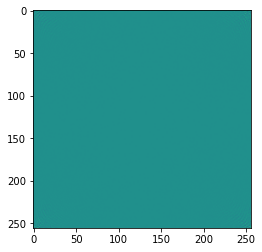

In [3]:
hf2 = h5py.File(r'D:\LB-NN-MONICA-KSPACE\Train-k-space.hdf5','r')
kspace2 = hf2[hf2['index'][1]]['VolumeKspace'][5][:,:,0]+1j*hf2[hf2['index'][1]]['VolumeKspace'][5][:,:,1]
img2 = ifft(kspace2)
plt.imshow(hf2[hf2['index'][1]]['VolumeKspace'][5][:,:,1])

In [4]:
itkimage = sitk.ReadImage(r'D:\LB-NN-MONICA-KSPACE\Masks-Monica\undersampl_0p15\ima_1.mhd')
itkarray = sitk.GetArrayFromImage(itkimage)
print(np.sum(itkarray)/(256*256))

0.1501007080078125


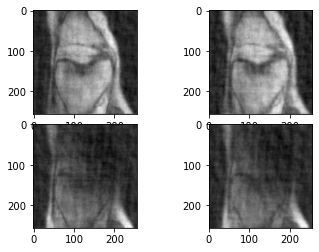

In [5]:
from NN.Masks import PolynomialMaskGenerator
input_mask = PolynomialMaskGenerator((256,256),sampling_factor=0.15,dim=2)
data_path = r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\train\file1000021.h5'
kspace = h5py.File(data_path,'r')['kspace_ground_truth'].value
kspace = kspace[0,:,:,0] + 1j*kspace[0,:,:,1]
mask_loic = itkarray*kspace
mask_gael = input_mask(kspace)
mask_loic = ifft(mask_loic)
mask_gael = ifft(mask_gael)
displ_loic = np.zeros((256,256,2),dtype=np.double)
displ_gael = np.zeros((256,256,2),dtype=np.double)
displ_loic[:,:,0] = np.real(mask_loic)
displ_loic[:,:,1] = np.imag(mask_loic)
displ_gael[:,:,0] = np.real(mask_gael)
displ_gael[:,:,1] = np.imag(mask_gael)
data_plot([displ_gael,displ_loic])

In [2]:
def ifft_layer(kspace):
    real = Lambda(lambda kspace : kspace[:,:,:,0])(kspace)
    imag = Lambda(lambda kspace : kspace[:,:,:,1])(kspace)
    kspace_complex = tf.complex(real,imag)
    # rec1 = tf.abs(tf.signal.ifft2d(kspace_complex))
    kspace_complex = tf.signal.ifftshift(kspace_complex,axes=[1,2])
    rec1 = tf.signal.ifft2d(kspace_complex)
    rec1 = tf.signal.fftshift(rec1,axes=[1,2])
    rec1 = tf.abs(rec1)#for loic images tf.abs(tf.signal.ifft2d(kspace_complex))
    rec1 = tf.expand_dims(rec1, -1)
    return rec1

def nrmse(y_true, y_pred):
    denom = tf.sqrt(tf.keras.backend.mean(tf.square(y_true), axis=(1,2,3)))
    return tf.sqrt(tf.keras.backend.mean(tf.square(y_pred - y_true), axis=(1,2,3)))\
    /denom

def reduced_nrmse(y_true, y_pred):
    denom = tf.sqrt(tf.keras.backend.mean(tf.square(y_true), axis=(1,2,3)))
    nrmse= tf.sqrt(tf.keras.backend.mean(tf.square(y_pred - y_true), axis=(1,2,3)))/denom
    return tf.reduce_mean(nrmse)

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # third layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    
#    print(input_img)
    # contracting path
#    input_img=(input_img-1000)/1000
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
   
    outkspace = Conv2D(2, (1, 1), activation='linear') (c9)
    
    outkspace_comb = Add()([outkspace,input_img])

    
    img_rec = Lambda(ifft_layer)(outkspace_comb)
    
    d1 = conv2d_block(img_rec, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    k1 = MaxPooling2D((2, 2)) (d1)
    k1 = Dropout(dropout*0.5)(k1)

    d2 = conv2d_block(k1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    k2 = MaxPooling2D((2, 2)) (d2)
    k2 = Dropout(dropout)(k2)

    d3 = conv2d_block(k2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    k3 = MaxPooling2D((2, 2)) (d3)
    k3 = Dropout(dropout)(k3)

    d4 = conv2d_block(k3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    k4 = MaxPooling2D(pool_size=(2, 2)) (d4)
    k4 = Dropout(dropout)(k4)
    
    d5 = conv2d_block(k4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    v6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (d5)
    v6 = concatenate([v6, d4])
    v6 = Dropout(dropout)(v6)
    d6 = conv2d_block(v6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    v7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (d6)
    v7 = concatenate([v7, d3])
    v7 = Dropout(dropout)(v7)
    d7 = conv2d_block(v7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    v8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (d7)
    v8 = concatenate([v8, d2])
    v8 = Dropout(dropout)(v8)
    d8 = conv2d_block(v8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    v9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (d8)
    v9 = concatenate([v9, d1], axis=3)
    v9 = Dropout(dropout)(v9)
    d9 = conv2d_block(v9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
   
    outimg = Conv2D(1, (1, 1), activation='linear') (d9)

    model = Model(inputs=[input_img], outputs=[outkspace_comb,outimg])
    return model



Initialization


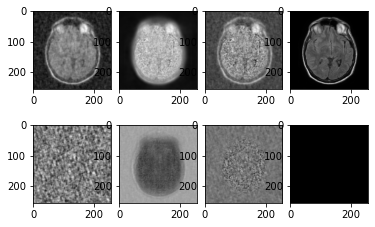

In [41]:
from generatorKspaceUnet3 import DataGenerator
from NN.architectures import reconGAN_Wnet_intermediate
train_gen = DataGenerator([r'D:\LB-NN-MONICA-KSPACE\Train-k-space-monica-15.hdf5'],batch_size=16, dim=(256,256),training=False)
model = reconGAN_Wnet_intermediate((256,256,2), 16, 16, skip=True,realimag_img=True, realimag_kspace=True,normalise_image=True,center_normalised_values=True,kernel_initializer='zeros')
model.load_weights(r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\trainingsaves_ReconGAN_Unet_kspace_to_img_intermoutput_ssimLoic_data_test_Mar_17_17_58\best.h5')
outp = model.predict(train_gen[0][0])
# print(outp[0].shape)
display = np.zeros((256,256,2),dtype=np.float)
display = outp[0][0]
kspace_compl_to_display = train_gen[0][0][0,:,:,0] + 1j*train_gen[0][0][0,:,:,1]
input_compl = np.fft.fftshift(ifft(kspace_compl_to_display))
input_todisplay = np.zeros((256,256,2), dtype=np.float)
input_todisplay[:,:,0] = np.real(input_compl)
input_todisplay[:,:,1] = np.imag(input_compl)
gt = np.zeros((256,256,2,1),dtype=np.float)
inpu = np.zeros((256,256,2,1),dtype=np.float)
inter_display = np.zeros((256,256,2),dtype=np.float)
inter_display[:,:,:] = outp[1][0]
gt[:,:,0,:] = train_gen[0][1][1][0]
data_plot([input_todisplay,inter_display,display,gt[:,:,:,0]])

(16, 256, 256, 1)


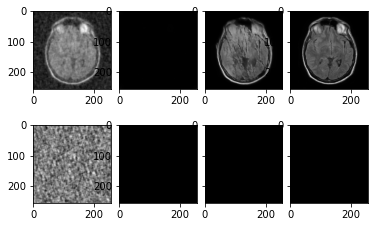

In [80]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Add, Lambda
from tensorflow.keras.models import Model
input_loic = Input((256,256,2))
model_loic = get_unet(input_loic, n_filters=16, dropout=0.05, batchnorm=True)
model_loic.load_weights(r'C:\Users\touquet\Documents\Code\DeepLearningForMRI\LB-NN-MONICA-KSPACE\kspace_gen_MS16.h5')
outp_loic = model_loic.predict(train_gen[0][0])
display_loic_compl_kspace = np.zeros((256,256,2),dtype=np.float)
display_loic_compl_kspace = outp_loic[0][0,:,:,0] + 1j*outp_loic[0][0,:,:,1]
inter_loic_compl_img = ifft(display_loic_compl_kspace)
inter_display_loic = np.zeros((256,256,2),dtype=np.float)
inter_display_loic[:,:,0] = np.abs(inter_loic_compl_img)
display_loic = np.zeros((256,256,2),dtype=np.float)
display_loic[:,:,0] = outp_loic[1][0,:,:,0]
data_plot([input_todisplay,inter_display_loic,display_loic,gt[:,:,:,0]])

Initialization


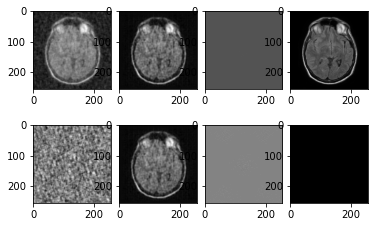

In [86]:
from generatorKspaceUnet3 import DataGenerator
from NN.architectures import reconGAN_Wnet_intermediate
train_gen = DataGenerator([r'D:\LB-NN-MONICA-KSPACE\Train-k-space-monica-15.hdf5'],batch_size=16, dim=(256,256),training=False)
model = reconGAN_Wnet_intermediate((256,256,2), 16, 16, skip=True,realimag_img=True, realimag_kspace=True,normalise_image=True,center_normalised_values=True,kernel_initializer='zeros')
json_file= r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\trainingsaves_ReconGAN_Unet_kspace_to_img_intermoutput_ssimLoic_data_arch_loss_Mar_18_14_42\model_save.json'
json_file = open(json_file, 'r')
model = model_from_json(json_file.read())
json_file.close()
model.load_weights(r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\trainingsaves_ReconGAN_Unet_kspace_to_img_intermoutput_ssimLoic_data_arch_loss_Mar_18_14_42\epoch05.h5')
outp = model.predict(train_gen[0][0])
# print(outp[0].shape)
display = np.zeros((256,256,2),dtype=np.float)
display = outp[0][0]
kspace_compl_to_display = train_gen[0][0][0,:,:,0] + 1j*train_gen[0][0][0,:,:,1]
input_compl = np.fft.fftshift(ifft(kspace_compl_to_display))
input_todisplay = np.zeros((256,256,2), dtype=np.float)
input_todisplay[:,:,0] = np.real(input_compl)
input_todisplay[:,:,1] = np.imag(input_compl)
gt = np.zeros((256,256,2,1),dtype=np.float)
inpu = np.zeros((256,256,2,1),dtype=np.float)
inter_display = np.zeros((256,256,2),dtype=np.float)
inter_display[:,:,:] = outp[1][0]
gt[:,:,0,:] = train_gen[0][1][1][0]
data_plot([input_todisplay,inter_display,display,gt[:,:,:,0]])

Initialization


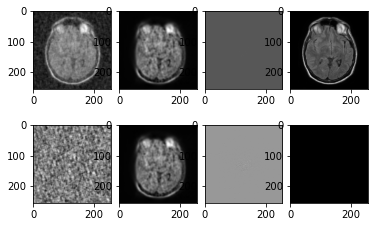

In [87]:
from generatorKspaceUnet3 import DataGenerator
from NN.architectures import reconGAN_Wnet_intermediate
train_gen = DataGenerator([r'D:\LB-NN-MONICA-KSPACE\Train-k-space-monica-15.hdf5'],batch_size=16, dim=(256,256),training=False)
model = reconGAN_Wnet_intermediate((256,256,2), 16, 16, skip=True,realimag_img=True, realimag_kspace=True,normalise_image=True,center_normalised_values=True,kernel_initializer='zeros')
json_file= r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\trainingsaves_ReconGAN_Unet_kspace_to_img_intermoutput_ssimLoic_data_justarch_Mar_18_16_09\model_save.json'
json_file = open(json_file, 'r')
model = model_from_json(json_file.read())
json_file.close()
model.load_weights(r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\trainingsaves_ReconGAN_Unet_kspace_to_img_intermoutput_ssimLoic_data_justarch_Mar_18_16_09\best.h5')
outp = model.predict(train_gen[0][0])
# print(outp[0].shape)
display = np.zeros((256,256,2),dtype=np.float)
display = outp[0][0]
kspace_compl_to_display = train_gen[0][0][0,:,:,0] + 1j*train_gen[0][0][0,:,:,1]
input_compl = np.fft.fftshift(ifft(kspace_compl_to_display))
input_todisplay = np.zeros((256,256,2), dtype=np.float)
input_todisplay[:,:,0] = np.real(input_compl)
input_todisplay[:,:,1] = np.imag(input_compl)
gt = np.zeros((256,256,2,1),dtype=np.float)
inpu = np.zeros((256,256,2,1),dtype=np.float)
inter_display = np.zeros((256,256,2),dtype=np.float)
inter_display[:,:,:] = outp[1][0]
gt[:,:,0,:] = train_gen[0][1][1][0]
data_plot([input_todisplay,inter_display,display,gt[:,:,:,0]])

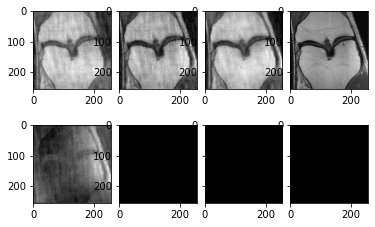

In [11]:
from generatorKspaceUnet3 import DataGenerator
from NN.Generators import DataGenerator_kspace_img_interm_kspace_onlyabsimg
from NN.architectures import reconGAN_Wnet_intermediate
train_gen = DataGenerator_kspace_img_interm_kspace_onlyabsimg(r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\train',batch_size=16)
# train_gen = DataGenerator([r'D:\LB-NN-MONICA-KSPACE\Train-k-space-monica-15.hdf5'],batch_size=16, dim=(256,256),training=False)
model = reconGAN_Wnet_intermediate((256,256,2), 16, 16, skip=True,realimag_img=True, realimag_kspace=True,normalise_image=True,center_normalised_values=True,kernel_initializer='zeros')
json_file= r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\trainingsaves_ReconGAN_Unet_kspace_to_img_intermoutput_ssim_Mar_19_08_17\model_save.json'
json_file = open(json_file, 'r')
model = model_from_json(json_file.read())
json_file.close()
model.load_weights(r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\trainingsaves_ReconGAN_Unet_kspace_to_img_intermoutput_ssim_Mar_19_08_17\best.h5')
outp = model.predict(train_gen[0][0])
# print(outp[0].shape)
display = np.zeros((256,256,2,1),dtype=np.float)
display[:,:,0,:] = outp[1][0]
kspace_compl_to_display = train_gen[0][0][0,:,:,0] + 1j*train_gen[0][0][0,:,:,1]
input_compl = ifft(kspace_compl_to_display)
input_todisplay = np.zeros((256,256,2), dtype=np.float)
input_todisplay[:,:,0] = np.real(input_compl)
input_todisplay[:,:,1] = np.imag(input_compl)
gt = np.zeros((256,256,2,1),dtype=np.float)
inter_display = np.zeros((256,256,2),dtype=np.float)
interk_compl = outp[0][0][:,:,0] +1j*outp[0][0][:,:,1]
interimg_compl = ifft(interk_compl)
inter_display[:,:,0] = np.abs(interimg_compl) 
gt[:,:,0,:] = train_gen[0][1][1][0]
data_plot([input_todisplay,inter_display,display,gt[:,:,:,0]])

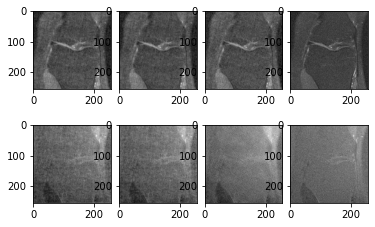

In [2]:
from generatorKspaceUnet3 import DataGenerator
from NN.Generators import DataGenerator_kspace_img_interm_kspace_onlyabsimg, DataGenerator_kspace_img_interm_kspace
from NN.architectures import reconGAN_Wnet_intermediate
train_gen = DataGenerator_kspace_img_interm_kspace(r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\train',batch_size=16)
# train_gen = DataGenerator([r'D:\LB-NN-MONICA-KSPACE\Train-k-space-monica-15.hdf5'],batch_size=16, dim=(256,256),training=False)
model = reconGAN_Wnet_intermediate((256,256,2), 16, 16, skip=True,realimag_img=True, realimag_kspace=True,normalise_image=True,center_normalised_values=True,kernel_initializer='zeros')
json_file= r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\trainingsaves_ReconGAN_Unet_kspace_to_img_intermoutput_ssim_Mar_19_10_56\model_save.json'
json_file = open(json_file, 'r')
model = model_from_json(json_file.read())
json_file.close()
model.load_weights(r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\trainingsaves_ReconGAN_Unet_kspace_to_img_intermoutput_ssim_Mar_19_10_56\best.h5')
outp = model.predict(train_gen[0][0])
# print(outp[0].shape)
display = np.zeros((256,256,2),dtype=np.float)
display[:,:,:] = outp[1][0]
kspace_compl_to_display = train_gen[0][0][0,:,:,0] + 1j*train_gen[0][0][0,:,:,1]
input_compl = ifft(kspace_compl_to_display)
input_todisplay = np.zeros((256,256,2), dtype=np.float)
input_todisplay[:,:,0] = np.real(input_compl)
input_todisplay[:,:,1] = np.imag(input_compl)
gt = np.zeros((256,256,2),dtype=np.float)
inter_display = np.zeros((256,256,2),dtype=np.float)
interk_compl = outp[0][0][:,:,0] +1j*outp[0][0][:,:,1]
interimg_compl = ifft(interk_compl)
inter_display[:,:,0] = np.real(interimg_compl) 
inter_display[:,:,1] = np.imag(interimg_compl) 
gt[:,:,:] = train_gen[0][1][1][0]
data_plot([input_todisplay,inter_display,display,gt])

In [3]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Add, Lambda
from tensorflow.keras.models import Model
from NN.Generators import DataGenerator_fullimg_abs_interm
batch_size = 12
train_gen = DataGenerator_fullimg_abs_interm(r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\train',batch_size=batch_size)
validation_generator = DataGenerator_fullimg_abs_interm(r'D:\NN_DATA\singlecoil_acc12_ksri_imgri_normed_zerocentered_10midslices_densedpointmasked\val',batch_size=batch_size)

input_loic = Input((256,256,2))
model_loic = get_unet(input_loic, n_filters=16, dropout=0.05, batchnorm=True)
model_loic.load_weights(r'C:\Users\touquet\Documents\Code\DeepLearningForMRI\kspace_gen_MS14.h5')
outp_loic = model_loic.predict(train_gen[0][0])
display_loic_compl_kspace = np.zeros((256,256,2),dtype=np.float)
display_loic_compl_kspace = outp_loic[0][0,:,:,0] + 1j*outp_loic[0][0,:,:,1]
inter_loic_compl_img = ifft(display_loic_compl_kspace)
inter_display_loic = np.zeros((256,256,2),dtype=np.float)
inter_display_loic[:,:,0] = np.abs(inter_loic_compl_img)
display_loic = np.zeros((256,256,2),dtype=np.float)
display_loic[:,:,0] = outp_loic[1][0,:,:,0]
# display_loic[:,:,1] = outp_loic[1][0,:,:,1]
absgt = np.zeros((256,256,2),dtype=np.float)
gt[:,:,:] = train_gen[0][1][1][0]
absgt[:,:,0] = np.abs(gt[:,:,0] + 1j*gt[:,:,1])
data_plot([input_todisplay,inter_display_loic,display_loic,absgt])

NameError: name 'gt' is not defined